In [1]:
from astropy.coordinates import EarthLocation, AltAz, ITRS, FK5, SkyCoord
from scipy import interpolate
import astropy.units as u
import numpy as np
from astropy.time import Time

In [2]:
from lofarantpos.db import LofarAntennaDatabase

In [3]:
from pyproj import Transformer

In [4]:
db = LofarAntennaDatabase()

In [5]:
loc_rs305 = EarthLocation(*(db.phase_centres["RS305LBA"] * u.m))
loc_de605 = EarthLocation(*(db.phase_centres["DE605LBA"] * u.m))
loc_aartfaac = EarthLocation(
    EarthLocation(lat=52.9153 * u.deg, lon=6.8698 * u.deg, height=20 * u.m)
)

In [6]:
dummytime = Time.now()

In [7]:
wgs84_to_rds = Transformer.from_crs(4326, 28992)
rds_to_wgs84 = Transformer.from_crs(28992, 4326)

In [8]:
def far_to_near(altaz_far, distance, obstime=None):
    """Add distance to AltAz instance"""
    if obstime is None:
        obstime = altaz_far.obstime
    return AltAz(
        location=altaz_far.location,
        obstime=obstime,
        az=altaz_far.az,
        alt=altaz_far.alt,
        distance=distance,
    )

In [9]:
def near_to_far(altaz_near):
    """Strip distance from AltAz instance"""
    return AltAz(
        location=altaz_near.location,
        obstime=altaz_near.obstime,
        az=altaz_near.az,
        alt=altaz_near.alt
    )

In [10]:
def distance_from_height(obs_altaz, height=100 * u.km):
    """From an AltAz pointing, find the distance to where it crosses a plane 100 km above Earth"""
    try_distances = np.linspace(50, 1000) * u.km
    try_altaz = far_to_near(obs_altaz, try_distances, obstime=dummytime)
    try_heights = EarthLocation(
        *(try_altaz.transform_to(ITRS(obstime=dummytime)).cartesian.xyz)
    ).height
    height_to_distance = interpolate.interp1d(
        try_heights.to(u.km), try_distances.to(u.km)
    )
    return height_to_distance(height) * u.km

In [11]:
def earthloc_at_height(obs_altaz, height=100 * u.km, obstime=dummytime):
    """From an AltAz pointing, find the EarthLocation at which point the line of sight is exactly at a given height (100km)"""
    distance = distance_from_height(obs_altaz, height)
    intersection_altaz = far_to_near(obs_altaz, distance)
    return EarthLocation(
        *(intersection_altaz.transform_to(ITRS(obstime=dummytime)).cartesian.xyz)
    )

In [12]:
def draw_fov(
    obsloc: EarthLocation,
    alt0,
    az0,
    fwhm=13 * u.deg,
    height=100 * u.km,
    num_segments=31,
    as_radec=False,
    obstime=dummytime,
):
    """
    Make well-known-text (WKT) representation of beam at a certain height
    Coordinate system is rijksdriehoeksstelsel valid in NL
    """
    nodes = []
    for angle_offset in np.linspace(0, 360, num_segments) * u.deg:
        alt = alt0 + 0.5 * fwhm * np.cos(angle_offset)
        az = az0 + 0.5 * fwhm * np.sin(angle_offset)
        obs_altaz = AltAz(location=obsloc, obstime=dummytime, alt=alt, az=az)
        loc = earthloc_at_height(obs_altaz, height=height)
        node = wgs84_to_rds.transform(loc.lat.degree, loc.lon.degree, loc.height.value)[
            :2
        ]
        nodes += [node]
    nodes += [nodes[0]]
    return (
        "POLYGON(("
        + ", ".join([f"{node[0]:.2f} {node[1]:.2f}" for node in nodes])
        + "))"
    )

In [13]:
alt_rs305 = 30 * u.deg

In [14]:
rs305_pointings = []
for az0 in np.array([200, 220, 240]) * u.deg:
    print(
        draw_fov(
            loc_rs305,
            alt_rs305,
            az0,
            fwhm=13.02 * u.deg,
            height=100 * u.km,
            obstime=Time("2020-12-13T17:00"),
            as_radec=False,
        )
    )
    rs305_pointings.append(
        AltAz(location=loc_rs305, alt=alt_rs305, az=az0, obstime=dummytime)
    )

POLYGON((205831.96 422675.86, 202683.62 423089.73, 199172.50 422302.96, 195349.58 420298.37, 191282.37 417060.34, 187063.36 412581.52, 182817.76 406875.34, 178718.61 400013.82, 174967.28 392106.47, 171811.05 383375.64, 169525.56 374176.38, 168366.21 364965.06, 168563.76 356368.47, 170229.23 349031.59, 173341.75 343600.87, 177716.71 340592.98, 183017.34 340287.30, 188806.27 342669.60, 194620.82 347444.89, 200048.03 354115.29, 204780.11 362103.20, 208614.99 370771.97, 211474.62 379604.50, 213359.07 388151.28, 214327.42 396085.04, 214471.63 403195.79, 213884.29 409320.57, 212656.13 414371.97, 210864.75 418299.12, 208573.09 421072.97, 205831.96 422675.86, 205831.96 422675.86))
POLYGON((165969.77 444681.37, 163152.76 446146.80, 159584.25 446608.00, 155306.26 446031.41, 150376.88 444379.23, 144880.51 441612.93, 138939.44 437702.29, 132740.89 432655.83, 126511.54 426507.59, 120559.84 419381.97, 115266.24 411518.38, 111026.81 403258.40, 108272.77 395112.19, 107329.01 387647.94, 108396.94 38148

In [15]:
de605_pointings = []
for rs305_altaz_far in rs305_pointings:
    rs305_altaz_near = far_to_near(
        rs305_altaz_far, distance_from_height(rs305_altaz_far, 100 * u.km)
    )
    de605_altaz_near = rs305_altaz_near.transform_to(
        AltAz(location=loc_de605, obstime=dummytime)
    )
    de605_pointings.append(de605_altaz_near)

In [16]:
for de605_pointing in de605_pointings:
    print(
        draw_fov(
            loc_de605,
            de605_pointing.alt,
            de605_pointing.az,
            fwhm=6.46 * u.deg,
            height=100 * u.km,
        )
    )

POLYGON((198070.44 381718.68, 198676.58 382219.44, 199111.52 383005.94, 199362.30 384053.61, 199419.55 385327.68, 199277.46 386783.14, 198934.43 388365.10, 198394.17 390009.69, 197667.39 391645.83, 196773.53 393197.84, 195742.14 394589.10, 194613.72 395746.27, 193438.66 396605.33, 192275.08 397116.88, 191185.47 397250.01, 190231.53 396995.96, 189468.80 396369.27, 188941.47 395406.56, 188678.42 394163.08, 188690.98 392707.58, 188972.91 391116.11, 189501.59 389466.93, 190241.07 387835.71, 191146.34 386291.15, 192167.26 384893.16, 193252.31 383691.90, 194351.81 382727.64, 195420.21 382031.09, 196417.55 381623.78, 197310.13 381518.37, 198070.44 381718.68, 198070.44 381718.68))
POLYGON((152609.67 407070.55, 153411.92 408153.16, 153832.03 409601.03, 153853.42 411372.54, 153467.90 413414.32, 152676.64 415660.23, 151492.08 418030.70, 149940.52 420433.04, 148065.02 422763.13, 145927.96 424908.92, 143613.84 426754.27, 141225.76 428190.23, 138880.06 429126.22, 136703.71 429494.34, 134822.33 42926

In [17]:
for de605_pointing in de605_pointings:
    print(f"- alt {de605_pointing.alt.deg:.1f}˚, az {de605_pointing.az.deg:.1f}˚")

- alt 53.1˚, az 333.6˚
- alt 37.7˚, az 318.8˚
- alt 27.5˚, az 319.1˚


In [18]:
for rs305_pointing in rs305_pointings:
    print(f"- alt {rs305_pointing.alt.deg:.1f}˚, az {rs305_pointing.az.deg:.1f}˚")

- alt 30.0˚, az 200.0˚
- alt 30.0˚, az 220.0˚
- alt 30.0˚, az 240.0˚


In [19]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.patheffects

In [20]:
hdu = fits.open("../A12_meteor/2020-08-13T02:04:56.4_16B.fits")[0]

In [21]:
wcs = WCS(hdu.header)

In [22]:
altaz_frame = AltAz(
    location=loc_aartfaac, obstime=Time(hdu.header["DATE-OBS"], format="fits")
)

In [23]:
tick_alt = [0.4, 10, 20, 30, 40, 50, 60, 70, 80, 90]
tickcoords = SkyCoord(alt=np.array(tick_alt) * u.deg, az=-90 * u.deg, frame=altaz_frame)

In [24]:
data = hdu.data.squeeze()

In [25]:
def draw_fov_aartfaac(
    obsloc_bf: EarthLocation,
    alt0,
    az0,
    obstime,
    fwhm=13 * u.deg,
    height=100 * u.km,
    num_segments=31,
):
    """
    Transform beamformed pointings to intersection at 100km height plane, transform to
    apparent ra-dec for aartfaac
    """
    nodes = []
    altaz_aartfaac_frame = AltAz(location=loc_aartfaac, obstime=obstime)
    for angle_offset in np.linspace(0, 360, num_segments) * u.deg:
        alt = alt0 + 0.5 * fwhm * np.cos(angle_offset)
        az = az0 + 0.5 * fwhm * np.sin(angle_offset)
        altaz_bf_far = AltAz(location=obsloc_bf, obstime=obstime, alt=alt, az=az)
        altaz_bf_near = far_to_near(
            altaz_bf_far, distance=distance_from_height(altaz_bf_far, 100 * u.km)
        )
        altaz_aartfaac_far = near_to_far(
            altaz_bf_near.transform_to(altaz_aartfaac_frame)
        )
        nodes += [altaz_aartfaac_far.transform_to(FK5)]
    nodes += [nodes[0]]
    return FK5(ra=[node.ra for node in nodes], dec=[node.dec for node in nodes])

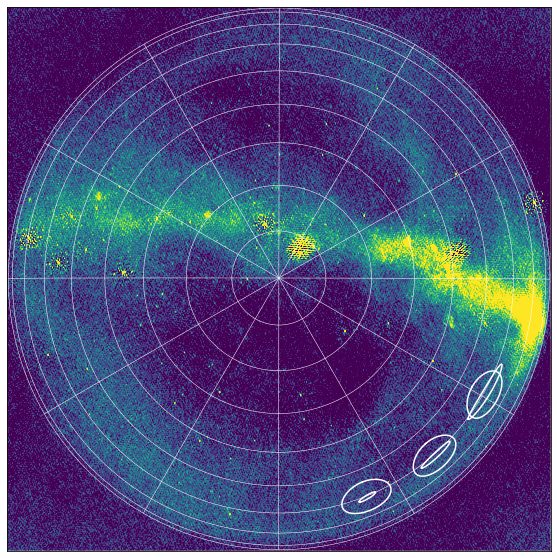

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs.celestial)
fig.add_axes(ax)
ax.imshow(
    data, origin="lower", vmin=np.quantile(data, 0.2), vmax=np.quantile(data, 0.99)
)
altaz_overlay = ax.get_coords_overlay(altaz_frame)
altaz_overlay.grid(color="white", lw=0.5)
altaz_overlay["alt"].set_ticks(
    np.array([0.5, 10, 20, 30, 40, 50, 60, 70, 80, 90]) * u.deg
)
altaz_overlay["az"].set_ticks(np.arange(0, 360, 30) * u.deg)

for p in rs305_pointings:
    fwhm = draw_fov_aartfaac(
        p.location,
        p.alt,
        p.az,
        Time(hdu.header["DATE-OBS"], format="fits"),
        fwhm=13.02 * u.deg,
    )
    ax.plot(fwhm.ra, fwhm.dec, transform=ax.get_transform("world"), color="white")
for p in de605_pointings:
    fwhm = draw_fov_aartfaac(
        p.location,
        p.alt,
        p.az,
        Time(hdu.header["DATE-OBS"], format="fits"),
        fwhm=6.46 * u.deg,
    )
    ax.plot(fwhm.ra, fwhm.dec, transform=ax.get_transform("world"), color="white");